In [19]:
import os.path
import json
from glob import glob
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

plt.style.use(['fivethirtyeight'])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 400)
pd.set_option('display.max_colwidth', 100)

colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
ops = ['put', 'get', 'delete']

In [2]:
specs = pd.read_json(os.path.expanduser('~/PycharmProjects/benchmarking_test/results/lsm_part' + 
                                        '/benchmark_part_lsm_specs.jsonl'), lines=True)
print(len(specs))
specs.head()

105


,spec,created_at,events,id,last_modified,status
0,"{'partitions': 8, 'seconds': 3600, 'value_length': 1024, 'key_space_size': 100000000, 'known_key...",2020-04-30 08:59:00.321243,"[{'msg': 'Cancelled as duplicate', 'hostname': 'master', 'time': '2020-04-30T09:35:57.903595'}]",d4712913-8ac0-11ea-b1d1-00155d010301,2020-04-30T09:35:57.903595,cancelled
1,"{'partitions': 4, 'seconds': 3600, 'value_length': 1024, 'key_space_size': 100000000, 'known_key...",2020-04-29 20:48:46.571357,"[{'msg': 'starting', 'hostname': 'ec2-35-164-210-77.us-west-2.compute.amazonaws.com', 'time': '2...",58db5279-8a7c-11ea-b1d1-00155d010301,2020-04-30T01:53:17.412197,succeeded
2,"{'partitions': 8, 'seconds': 3600, 'value_length': 1024, 'key_space_size': 100000000, 'known_key...",2020-04-30 08:59:00.805861,"[{'msg': 'Cancelled as duplicate', 'hostname': 'master', 'time': '2020-04-30T09:35:57.990984'}]",d4712919-8ac0-11ea-b1d1-00155d010301,2020-04-30T09:35:57.990984,cancelled
3,"{'partitions': 4, 'seconds': 3600, 'value_length': 1024, 'key_space_size': 100000000, 'known_key...",2020-04-30 09:38:35.072395,"[{'msg': 'starting', 'hostname': 'ec2-54-202-73-17.us-west-2.compute.amazonaws.com', 'time': '20...",5ca56830-8ac6-11ea-b1d1-00155d010301,2020-04-30T10:44:13.088074,running
4,"{'partitions': 8, 'seconds': 3600, 'value_length': 1024, 'key_space_size': 100000000, 'known_key...",2020-04-29 20:48:46.144531,"[{'msg': 'starting', 'hostname': 'ec2-54-185-79-69.us-west-2.compute.amazonaws.com', 'time': '20...",58db5274-8a7c-11ea-b1d1-00155d010301,2020-04-30T01:53:23.852221,succeeded


In [3]:
specs['status'].value_counts()

cancelled    45
succeeded    31
running      16
pending      13
Name: status, dtype: int64

In [4]:
results = pd.read_json(os.path.expanduser('~/PycharmProjects/benchmarking_test/results/lsm_part' + 
                                          '/benchmark_part_lsm_results.jsonl'), lines=True, convert_dates=False)
print(len(results))
results.sample(5)

13796


,delete,get_found,spec_id,delete_found,get,file_size,put,nano_time
1301,262371,27342,58db5275-8a7c-11ea-b1d1-00155d010301,262371,269273,40426198333,262617,4383721447968
2084,12651,3848,5aa705ba-8ac6-11ea-b1d1-00155d010301,12651,12617,79019040061,229662,1444535149206
2959,36537,82683,5b6b2909-8ac6-11ea-b1d1-00155d010301,36537,620679,32094405543,73171,2989536462652
9417,172089,22009,58db5272-8a7c-11ea-b1d1-00155d010301,172089,177015,35191454198,172051,1689653161264
3288,516472,95766,d4712916-8ac0-11ea-b1d1-00155d010301,516472,531557,36324549207,516171,1054742872944


In [36]:
constant_parameters = ['seconds', 'value_length', 'key_space_size', 'known_key_rate_percent', 'trial_index',
                       'pending_write_merge_threshold', 'index_rate']

In [38]:
spec_values = pd.concat([specs[['id', 'status']], pd.DataFrame(list(specs['spec']), index=specs.index)], axis=1)
spec_values['workload'] = spec_values['put_del_get']
spec_values['index_rate'] = spec_values['base_index_rate']
spec_values = spec_values.drop(['put_del_get', 'base_index_rate'], axis=1)
for param in constant_parameters:
    assert spec_values[param].nunique() == 1, f'{param} is not constant'
spec_values = spec_values.drop(constant_parameters, axis=1)
spec_values.sample(5)

,id,status,partitions,thread_count,workload
91,5aa705c0-8ac6-11ea-b1d1-00155d010301,running,4,16,PUT_HEAVY
46,d471291a-8ac0-11ea-b1d1-00155d010301,cancelled,1,16,BALANCED
37,5aa705b8-8ac6-11ea-b1d1-00155d010301,running,8,1,PUT_HEAVY
62,5b6b2911-8ac6-11ea-b1d1-00155d010301,succeeded,8,32,GET_HEAVY
88,d36ff0fe-8ac0-11ea-b1d1-00155d010301,cancelled,4,1,BALANCED


In [39]:
grouped_results = []
for spec_id, spec_results in results.groupby('spec_id'):
    spec_results = spec_results.sort_values('nano_time')
    spec_results['t'] = (spec_results['nano_time'] - spec_results['nano_time'].iloc[0]) / 1e9
    grouped_results.append({
        'spec_id': spec_id,
        'results': spec_results,
        'final_file_size': spec_results['file_size'].iloc[-1],
        'sum_put': spec_results['put'].sum(),
        'sum_get': spec_results['get'].sum(),
        'sum_delete': spec_results['delete'].sum()
    })
grouped_results = pd.DataFrame(grouped_results)
grouped_results = pd.concat([spec_values.set_index('id'), grouped_results.set_index('spec_id')], axis=1)
grouped_results = grouped_results.dropna()
grouped_results = grouped_results[grouped_results['status'].isin(['succeeded', 'running'])]
grouped_results.sample(5).T

,5ca56830-8ac6-11ea-b1d1-00155d010301,5b6b2918-8ac6-11ea-b1d1-00155d010301,5b6b2912-8ac6-11ea-b1d1-00155d010301,58db5272-8a7c-11ea-b1d1-00155d010301,58db5276-8a7c-11ea-b1d1-00155d010301
status,running,succeeded,succeeded,succeeded,succeeded
partitions,4,1,1,1,4
thread_count,8,8,1,1,4
workload,DELETE_HEAVY,DELETE_HEAVY,DELETE_HEAVY,BALANCED,BALANCED
results,delete get_found spec_id delete_found get file_size...,delete get_found spec_id delete_found get file_si...,delete get_found spec_id delete_found get file_si...,delete get_found spec_id delete_found get file_si...,delete get_found spec_id delete_found get file_s...
final_file_size,5.1002e+10,1.05929e+11,6.1966e+10,3.87809e+10,7.24394e+10
sum_put,4.4201e+07,1.33837e+08,8.2246e+07,5.26238e+07,1.08218e+08
sum_get,9.82222e+06,2.97358e+07,1.82653e+07,5.42169e+07,1.11505e+08
sum_delete,4.41955e+07,1.33846e+08,8.22319e+07,5.26206e+07,1.0823e+08


In [40]:
grouped_results['status'].value_counts()

succeeded    31
running      16
Name: status, dtype: int64

In [9]:
thread_to_color = dict(zip(sorted(set(spec_values['thread_count'])), colors))
partition_to_ls = dict(zip(sorted(set(spec_values['partitions'])), ['-', '--', ':']))

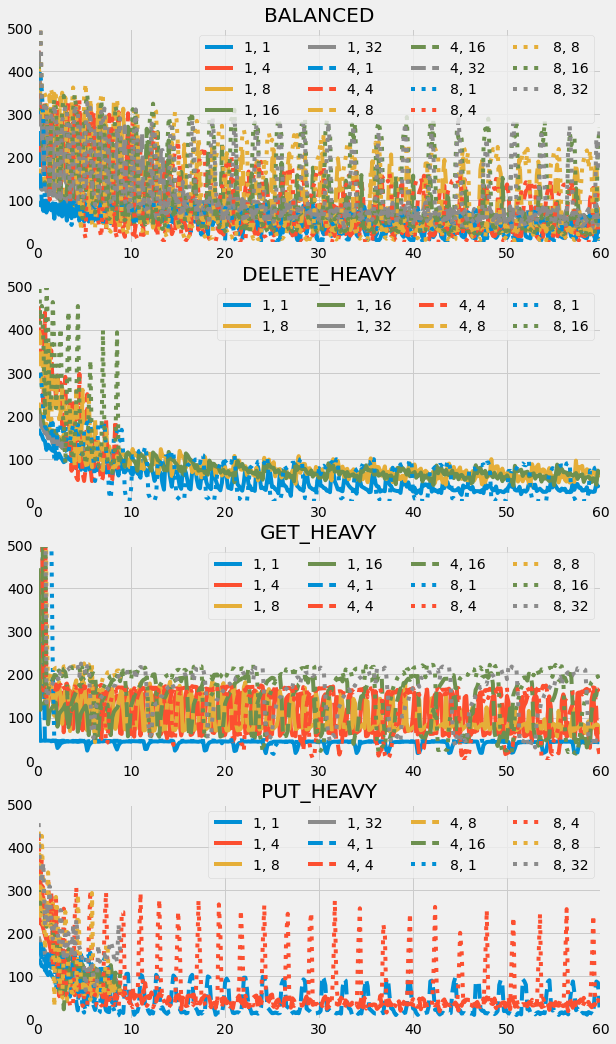

In [41]:
def diff(x):
    return x.iloc[1::].reset_index(drop=True) - x.iloc[:-1:].reset_index(drop=True)


fig = plt.figure(figsize=(9, 17))
for i, (workload, workload_df) in enumerate(grouped_results.groupby('workload')):
    ax = fig.add_subplot(4, 1, i+1)
    #print(workload, len(workload_df))
    
    for spec_id, spec_row in workload_df.sort_values(['partitions', 'thread_count']).iterrows():
        #print(workload, f"{spec_row['partitions']}, {spec_row['thread_count']}")
        row_results = spec_row['results']
        t = row_results['t'] / 60
        ops_sec = (row_results[['put', 'get', 'delete']].sum(axis=1).iloc[1::].reset_index(drop=True) /
                   diff(row_results['t']))
        ops_sec /= 1000
        ax.plot(t.iloc[1::], ops_sec,
                label=f"{spec_row['partitions']}, {spec_row['thread_count']}",
                color=thread_to_color[spec_row['thread_count']],
                ls=partition_to_ls[spec_row['partitions']])
    ax.legend(loc='upper right', ncol=4)
    ax.set_title(workload)
    plt.ylim(0, 500)
    plt.xlim(0, 60)
#plt.xlim(0, 5)

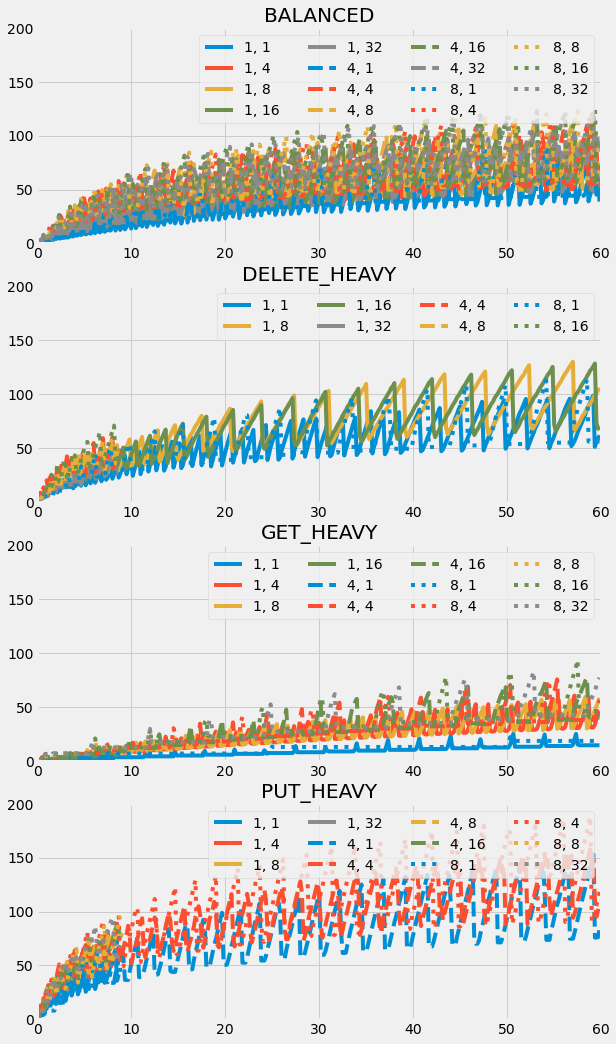

In [42]:
fig = plt.figure(figsize=(9, 17))
for i, (workload, workload_df) in enumerate(grouped_results.groupby('workload')):
    ax = fig.add_subplot(4, 1, i+1)    
    for spec_id, spec_row in workload_df.sort_values(['partitions', 'thread_count']).iterrows():
        row_results = spec_row['results']
        ax.plot(row_results['t'] / 60, row_results['file_size'] / 1e9,
                label=f"{spec_row['partitions']}, {spec_row['thread_count']}",
                color=thread_to_color[spec_row['thread_count']],
                ls=partition_to_ls[spec_row['partitions']])
    ax.legend(loc='upper right', ncol=4)
    ax.set_title(workload)
    plt.ylim(0, 200)
    plt.xlim(0, 60)


In [45]:
normed_results = grouped_results.copy()
normed_results['duration_seconds'] = normed_results['results'].map(lambda r: r['t'].max())
for op in ops:
    normed_results[op] = normed_results['sum_' + op] / normed_results['duration_seconds'] / 1000
normed_results = normed_results.drop(['results'] + ['sum_' + op for op in ops], axis=1)
normed_results['sum'] = normed_results[ops].sum(axis=1)
normed_results['final_file_size'] /= 1e9
normed_results = normed_results.set_index(['workload', 'partitions', 'thread_count'])
normed_results.sample(5)

status  final_file_size  duration_seconds        put         get     delete         sum
workload     partitions thread_count                                                                                            
DELETE_HEAVY 1          16            succeeded        69.791905       3591.378460  36.246767    8.057582  36.241011   80.545361
GET_HEAVY    8          16            succeeded        46.035450       3590.810032  18.942879  160.985568   9.472496  189.400942
                        8               running        12.408962        530.198100  30.971126  263.149645  15.483166  309.603937
DELETE_HEAVY 1          8             succeeded       105.929045       3590.957497  37.270570    8.280731  37.272956   82.824257
BALANCED     8          32            succeeded        60.848159       3591.178646  41.787819   43.052204  41.783401  126.623424

In [49]:
norm_succeeded = normed_results[normed_results['status'] == 'succeeded']

status  final_file_size  duration_seconds        put         get     delete         sum
workload     partitions thread_count                                                                                            
GET_HEAVY    8          16            succeeded        46.035450       3590.810032  18.942879  160.985568   9.472496  189.400942
                        32            succeeded        76.962185       3590.609781  18.118432  153.996258   9.055363  181.170053
                        4             succeeded        40.216455       3590.767194  16.003534  136.033787   8.002108  160.039429
             4          16            succeeded        40.056826       3590.677592  15.329707  130.324766   7.667655  153.322127
                        4             succeeded        56.510684       3590.509995  14.452238  122.831384   7.225513  144.509135
BALANCED     8          16            succeeded        61.435646       3591.901284  42.012983   43.283298  42.004817  127.301098
                        32            succeeded        60.848159       3591.178646  41.787819   43.052204  41.783401  126.623424
                        8             succeeded        92.835070       3591.496975  40.022578   41.238154  40.021766  121.282498
GET_HEAVY    1          4             succeeded        45.954238       3590.511110  10.636158   90.419845   5.318613  106.374616
BALANCED     8          4             succeeded        58.077695       3591.073987  34.481184   35.523195  34.477791  104.482170
GET_HEAVY    1          8             succeeded        58.210882       3590.557145  10.398139   88.357040   5.198205  103.953384
BALANCED     4          32            succeeded        83.271413       3591.101595  33.133399   34.132285  33.127089  100.392773
                        16            succeeded        72.528941       3592.084559  32.999294   33.995224  32.995336   99.989854
                        8             succeeded        67.758082       3591.011967  32.792746   33.793550  32.796212   99.382508
                        4             succeeded        72.439393       3591.451628  30.132166   31.047311  30.135328   91.314804
DELETE_HEAVY 1          8             succeeded       105.929045       3590.957497  37.270570    8.280731  37.272956   82.824257
                        16            succeeded        69.791905       3591.378460  36.246767    8.057582  36.241011   80.545361
PUT_HEAVY    8          4             succeeded       118.568020       3591.801291  65.724443    3.650343   3.651433   73.026219
DELETE_HEAVY 8          1             succeeded        56.199717       3590.953240  31.697789    7.046619  31.702551   70.446959
BALANCED     8          1             succeeded        62.173105       3590.998572  21.669390   22.326736  21.666263   65.662389
             1          8             succeeded        75.323682       3590.630442  21.357678   22.002702  21.356433   64.716813
                        4             succeeded        51.885263       3590.659933  21.302694   21.950014  21.305268   64.557976
                        16            succeeded        65.194732       3590.616899  21.165198   21.807458  21.167328   64.139985
GET_HEAVY    8          1             succeeded        18.340001       3590.438314   6.256540   53.211257   3.129985   62.597781
BALANCED     1          32            succeeded        58.512165       3590.844217  20.551221   21.170342  20.553480   62.275043
             4          1             succeeded        45.245574       3590.605954  19.793253   20.394126  19.793306   59.980686
PUT_HEAVY    4          4             succeeded       106.786969       3591.236499  46.963280    2.608986   2.609474   52.181740
DELETE_HEAVY 1          1             succeeded        61.966049       3590.750490  22.904952    5.086769  22.901032   50.892753
BALANCED     1          1             succeeded        38.780916       3590.603005  14.655966   15.099651  14.655085   44.410702
GET_HEAVY    1          1             succ

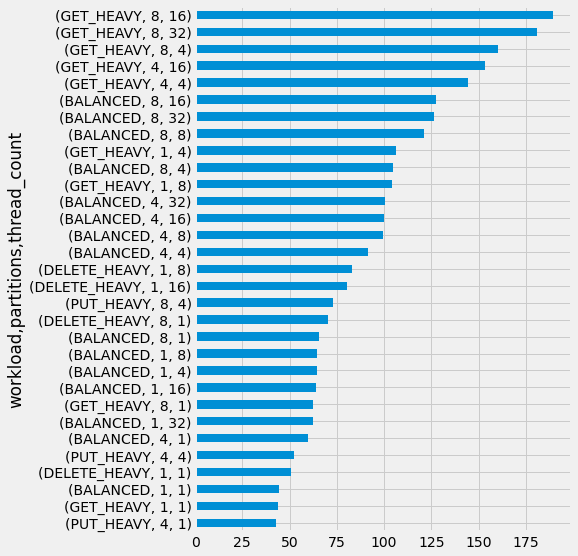

In [50]:
x = norm_succeeded.sort_values('sum', ascending=False)
display(x)
x['sum'].iloc[::-1].plot.barh(figsize=(6,9))

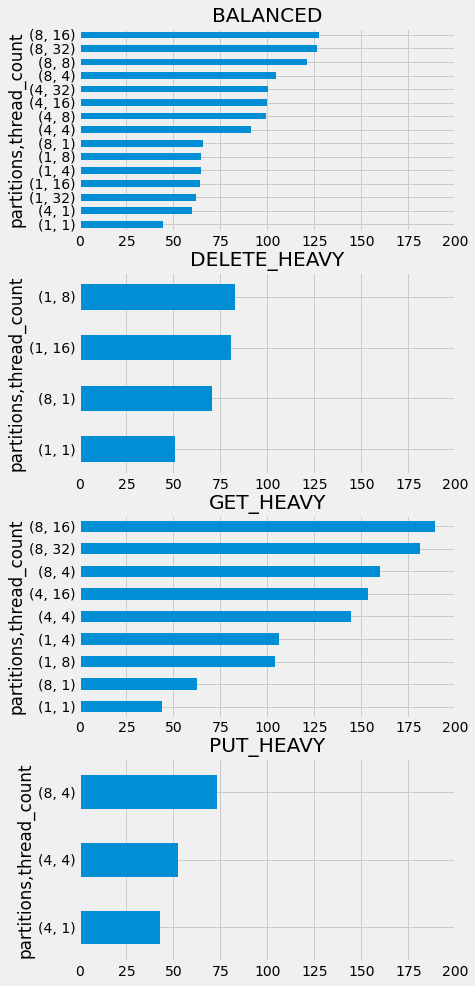

In [54]:
fig = plt.figure(figsize=(6, 16))
for i, (workload, workload_df) in enumerate(norm_succeeded.groupby('workload')):
    ax = fig.add_subplot(4, 1, i+1)
    ax.set_title(workload)
    workload_df = workload_df.reset_index().set_index(['partitions', 'thread_count'])
    workload_df['sum'].sort_values(ascending=True).plot.barh(ax=ax)
    plt.xlim(0, 200)


status  final_file_size  duration_seconds        put         get     delete         sum
workload     partitions thread_count                                                                                            
PUT_HEAVY    8          4             succeeded       118.568020       3591.801291  65.724443    3.650343   3.651433   73.026219
             4          4             succeeded       106.786969       3591.236499  46.963280    2.608986   2.609474   52.181740
DELETE_HEAVY 1          8             succeeded       105.929045       3590.957497  37.270570    8.280731  37.272956   82.824257
BALANCED     8          8             succeeded        92.835070       3591.496975  40.022578   41.238154  40.021766  121.282498
PUT_HEAVY    4          1             succeeded        84.239681       3591.626139  38.720332    2.151660   2.150574   43.022566
BALANCED     4          32            succeeded        83.271413       3591.101595  33.133399   34.132285  33.127089  100.392773
GET_HEAVY    8          32            succeeded        76.962185       3590.609781  18.118432  153.996258   9.055363  181.170053
BALANCED     1          8             succeeded        75.323682       3590.630442  21.357678   22.002702  21.356433   64.716813
             4          16            succeeded        72.528941       3592.084559  32.999294   33.995224  32.995336   99.989854
                        4             succeeded        72.439393       3591.451628  30.132166   31.047311  30.135328   91.314804
DELETE_HEAVY 1          16            succeeded        69.791905       3591.378460  36.246767    8.057582  36.241011   80.545361
BALANCED     4          8             succeeded        67.758082       3591.011967  32.792746   33.793550  32.796212   99.382508
             1          16            succeeded        65.194732       3590.616899  21.165198   21.807458  21.167328   64.139985
             8          1             succeeded        62.173105       3590.998572  21.669390   22.326736  21.666263   65.662389
DELETE_HEAVY 1          1             succeeded        61.966049       3590.750490  22.904952    5.086769  22.901032   50.892753
BALANCED     8          16            succeeded        61.435646       3591.901284  42.012983   43.283298  42.004817  127.301098
                        32            succeeded        60.848159       3591.178646  41.787819   43.052204  41.783401  126.623424
             1          32            succeeded        58.512165       3590.844217  20.551221   21.170342  20.553480   62.275043
GET_HEAVY    1          8             succeeded        58.210882       3590.557145  10.398139   88.357040   5.198205  103.953384
BALANCED     8          4             succeeded        58.077695       3591.073987  34.481184   35.523195  34.477791  104.482170
GET_HEAVY    4          4             succeeded        56.510684       3590.509995  14.452238  122.831384   7.225513  144.509135
DELETE_HEAVY 8          1             succeeded        56.199717       3590.953240  31.697789    7.046619  31.702551   70.446959
BALANCED     1          4             succeeded        51.885263       3590.659933  21.302694   21.950014  21.305268   64.557976
GET_HEAVY    8          16            succeeded        46.035450       3590.810032  18.942879  160.985568   9.472496  189.400942
             1          4             succeeded        45.954238       3590.511110  10.636158   90.419845   5.318613  106.374616
BALANCED     4          1             succeeded        45.245574       3590.605954  19.793253   20.394126  19.793306   59.980686
GET_HEAVY    8          4             succeeded        40.216455       3590.767194  16.003534  136.033787   8.002108  160.039429
             4          16            succeeded        40.056826       3590.677592  15.329707  130.324766   7.667655  153.322127
BALANCED     1          1             succeeded        38.780916       3590.603005  14.655966   15.099651  14.655085   44.410702
GET_HEAVY    8          1             succ

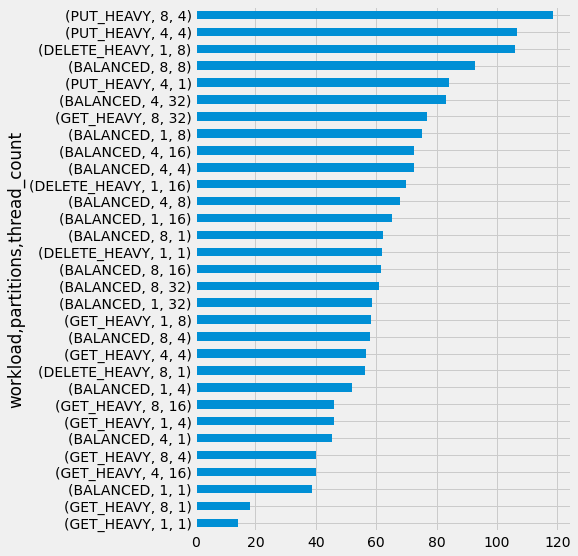

In [55]:
x = norm_succeeded.sort_values('final_file_size', ascending=False)
display(x)
x['final_file_size'].iloc[::-1].plot.barh(figsize=(6,9))